In [125]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import KFold, train_test_split, cross_val_score
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.svm import SVR
from sklearn.neural_network import MLPRegressor
from sklearn.preprocessing import LabelEncoder, StandardScaler, PolynomialFeatures
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error

In [32]:
# function for processing and simplifying the dataset
def select_and_rename(df, mapping):
    """
    Helper: Selects columns of df using the keys of the mapping dict.
    It renames the columns to the values of the mappings dict.
    """
    # select subset of columns
    dff = df[list(mapping.keys())]
    # rename 
    for k, v in mapping.items():
        dff.rename(columns={k: v}, inplace=True)
    return dff

def replaceSize(df):
    df["size"] = df["size"].str.replace("ab -c 1 -t 60 -n 99999999 -e /tngbench_share/ab_dist.csv -s 60 -k -i http://20.0.0.254:8888/", "small")
    df["size"] = df["size"].str.replace("ab -c 1 -t 60 -n 99999999 -e /tngbench_share/ab_dist.csv -s 60 -k http://20.0.0.254:8888/bunny.mp4", "big")
    df["size"] = df["size"].str.replace("ab -c 1 -t 60 -n 99999999 -e /tngbench_share/ab_dist.csv -s 60 -k -i -X 20.0.0.254:3128 http://40.0.0.254:80/", "small")
    df["size"] = df["size"].str.replace("ab -c 1 -t 60 -n 99999999 -e /tngbench_share/ab_dist.csv -s 60 -k -X 20.0.0.254:3128 http://40.0.0.254:80/bunny.mp4", "big")
    return df

In [33]:
# Load data from path
web1 = pd.read_csv("vnf_data/csv_experiments_WEB1.csv")
web2 = pd.read_csv("vnf_data/csv_experiments_WEB2.csv")
web3 = pd.read_csv("vnf_data/csv_experiments_WEB3.csv")

# do processing, renaming and selection
web1["vnf"] = "nginx"
web2["vnf"] = "haproxy"
web3["vnf"] = "squid"

mapping = {
    "param__func__mp.input__cmd_start": "size",
    "metric__mp.input.vdu01.0__ab_transfer_rate_kbyte_per_second": "throughput",
}

mapping01 = mapping.copy()
mapping01["param__func__de.upb.lb-nginx.0.1__cpu_bw"] = "CPU"

mapping02 = mapping.copy()
mapping02["param__func__de.upb.lb-haproxy.0.1__cpu_bw"] = "CPU"

mapping03 = mapping.copy()
mapping03["param__func__de.upb.px-squid.0.1__cpu_bw"] = "CPU"

web1 = select_and_rename(web1, mapping01)
web2 = select_and_rename(web2, mapping02)
web3 = select_and_rename(web3, mapping03)

web1 = replaceSize(web1)
web2 = replaceSize(web2)
web3 = replaceSize(web3)

c:\users\stefan\git-repos\work\ai\venv\lib\site-packages\pandas\core\frame.py:3781: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  return super(DataFrame, self).rename(**kwargs)


In [42]:
# select sub-datasets with small and large flows
web1_small = web1.loc[web1["size"] == "small"]
web1_big = web1.loc[web1["size"] == "big"]

web2_small = web2.loc[web2["size"] == "small"]
web2_big = web2.loc[web2["size"] == "big"]

web3_small = web3.loc[web3["size"] == "small"]
web3_big = web3.loc[web3["size"] == "big"]

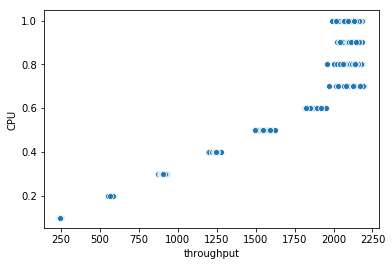

In [74]:
# plot cpu and throughput
# sns.scatterplot(web1_small['throughput'], web1_small['CPU'])
# sns.scatterplot(web1_big['throughput'], web1_big['CPU'])
# sns.scatterplot(web2_small['throughput'], web2_small['CPU'])
# sns.scatterplot(web2_big['throughput'], web2_big['CPU'])
sns.scatterplot(web3_small['throughput'], web3_small['CPU'])
# sns.scatterplot(web3_big['throughput'], web3_big['CPU'])

In [113]:
def display_scores(scores):
    print(f"Mean: {scores.mean()}")
    print(f"Std: {scores.std()}")
    
def do_cv(model, X_train, y_train):
    # train score
    print("Train score:")
    model.fit(X_train, y_train)
    y_train_pred = model.predict(X_train)
    rmse = np.sqrt(mean_squared_error(y_train, y_train_pred))
    display_scores(rmse)
    
    # CV score
    print("CV score:")
    scores = cross_val_score(model, X_train, y_train, scoring="neg_mean_squared_error", cv=5)
    rmse = np.sqrt(-scores)
    display_scores(rmse)
    
def predict_plot_all(model, X, y):
    name = type(model).__name__
    model.fit(X, y)
    y_pred = model.predict(X)
    plt.scatter(X, y, label='True')
    plt.scatter(X, y_pred, label=name)
    plt.legend()
    
    
def check_model(data, model):
    """Do test, train split; k-fold CV; and visualize"""
    name = type(model).__name__
    print(f"\n{name}")
    
    # prepare train and test set
    X = data[['throughput']]
    y = data['CPU']
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)
    
    do_cv(model, X_train, y_train)
    predict_plot_all(model, X, y)


LinearRegression
Train score:
Mean: 0.09299633727954208
Std: 0.0
CV score:
Mean: 0.09369831459130815
Std: 0.0027798419227087006

RandomForestRegressor
Train score:
Mean: 0.03321977457206848
Std: 0.0
CV score:
Mean: 0.08894524759807639
Std: 0.0037695091932715293

MLPRegressor
Train score:


c:\users\stefan\git-repos\work\ai\venv\lib\site-packages\sklearn\ensemble\forest.py:248: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


Mean: 0.10579767240441905
Std: 0.0
CV score:
Mean: 0.13225596259679095
Std: 0.029875641766442074


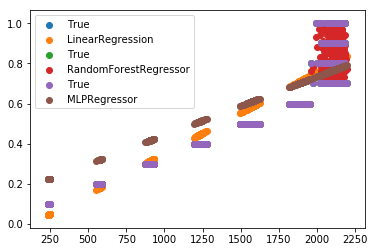

In [126]:
data = web3_small
check_model(data, LinearRegression())
# check_model(data, Ridge())
# check_model(data, SVR())
check_model(data, RandomForestRegressor())
# check_model(data, GradientBoostingRegressor())
check_model(data, MLPRegressor())